In [17]:
import torch
import torch.nn as nn

In [18]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

In [19]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3,stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [20]:
X = torch.randn(1,1,224,224)

In [23]:
def look_in_net(net, X):
    out = X
    
    for layer in net:
        out = layer(out)
        print(f"For layer {layer.__class__.__name__} : {out.shape}")

In [24]:
look_in_net(net,X)

For layer Sequential : torch.Size([1, 96, 54, 54])
For layer MaxPool2d : torch.Size([1, 96, 26, 26])
For layer Sequential : torch.Size([1, 256, 26, 26])
For layer MaxPool2d : torch.Size([1, 256, 12, 12])
For layer Sequential : torch.Size([1, 384, 12, 12])
For layer MaxPool2d : torch.Size([1, 384, 5, 5])
For layer Dropout : torch.Size([1, 384, 5, 5])
For layer Sequential : torch.Size([1, 10, 5, 5])
For layer AdaptiveAvgPool2d : torch.Size([1, 10, 1, 1])
For layer Flatten : torch.Size([1, 10])


In [25]:
device = torch.device('cuda')

In [26]:
net = net.to(device)

In [27]:
from torchsummary import summary

In [28]:
summary(net, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

In [29]:
batch_size = 128

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

my_transforms = transforms.Compose(
                [
                 transforms.Resize(224),
                 transforms.ToTensor()
                ]
)

train_dataset = datasets.FashionMNIST(download=False, root="../../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../../data", train=False, transform=my_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [31]:
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1)==y).sum().float().mean()

In [36]:
acc_arr = []

def train_net(net, num_epochs=3,lr=0.1):
    net = net
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    num_epochs = num_epochs
    
    acc_arr = []

    for epoch in range(num_epochs):
        acc_val = 0
        number = 0
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = net(X)
            l = criterion(pred, y)

            acc_val += accuracy(pred,y)
            number += len(y)

            optimizer.zero_grad()

            l.backward()

            optimizer.step()

        acc_arr.append(acc_val.detach().cpu()/number)
        print(f"Epoch {epoch} accuracy : {acc_arr[-1]}")
    
    return acc_arr
    

In [37]:
%%time
acc_arr = train_net(net,num_epochs=3)

Epoch 0 accuracy : 0.09978333115577698
Epoch 1 accuracy : 0.10046666860580444
Epoch 2 accuracy : 0.10001666843891144
Wall time: 9min 9s


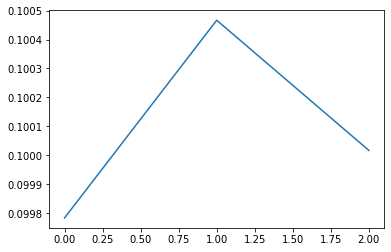

In [39]:
import matplotlib.pyplot as plt
plt.plot(range(3), acc_arr)
plt.show()

In [40]:
# trying to remove one of the convBlock

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

In [47]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3,stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [48]:
look_in_net(net, X)

For layer Sequential : torch.Size([1, 96, 54, 54])
For layer MaxPool2d : torch.Size([1, 96, 26, 26])
For layer Sequential : torch.Size([1, 256, 26, 26])
For layer MaxPool2d : torch.Size([1, 256, 12, 12])
For layer Sequential : torch.Size([1, 384, 12, 12])
For layer MaxPool2d : torch.Size([1, 384, 5, 5])
For layer Dropout : torch.Size([1, 384, 5, 5])
For layer Sequential : torch.Size([1, 10, 5, 5])
For layer AdaptiveAvgPool2d : torch.Size([1, 10, 1, 1])
For layer Flatten : torch.Size([1, 10])


In [49]:
net = net.to(device)
summary(net, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
         MaxPool2d-5           [-1, 96, 26, 26]               0
            Conv2d-6          [-1, 256, 26, 26]         614,656
              ReLU-7          [-1, 256, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]          65,792
              ReLU-9          [-1, 256, 26, 26]               0
        MaxPool2d-10          [-1, 256, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]         885,120
             ReLU-12          [-1, 384, 12, 12]               0
           Conv2d-13          [-1, 384, 12, 12]         147,840
             ReLU-14          [-1, 384,

In [50]:
%%time
acc_arr = train_net(net,num_epochs=3)

Epoch 0 accuracy : 0.1005999967455864
Epoch 1 accuracy : 0.14839999377727509
Epoch 2 accuracy : 0.40488332509994507
Wall time: 6min 41s


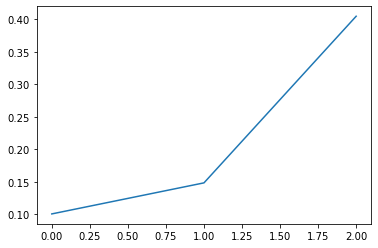

In [51]:
plt.plot(range(3), acc_arr)
plt.show()

In [52]:
# 3

#it might be too fast,may miss parameters

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.91E-01


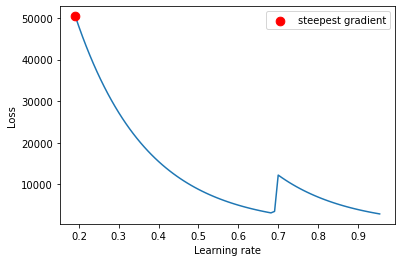

In [53]:
from torch_lr_finder import LRFinder

model = net
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
lr_finder = LRFinder(model, optimizer, criterion, device=device)

lr_finder.range_test(train_dataloader, val_loader=test_dataloader, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [54]:
%%time
acc_arr = train_net(net,num_epochs=10, lr=1.91e-01)

Epoch 0 accuracy : 0.15684999525547028
Epoch 1 accuracy : 0.10000000149011612
Epoch 2 accuracy : 0.10000000149011612
Epoch 3 accuracy : 0.10000000149011612
Epoch 4 accuracy : 0.10000000149011612
Epoch 5 accuracy : 0.10000000149011612
Epoch 6 accuracy : 0.10000000149011612
Epoch 7 accuracy : 0.10000000149011612
Epoch 8 accuracy : 0.10000000149011612
Epoch 9 accuracy : 0.10000000149011612
Wall time: 22min 8s


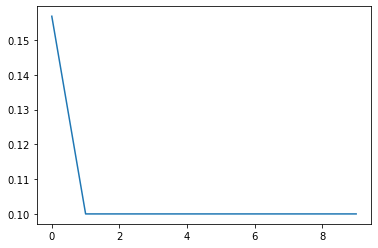

In [56]:
plt.plot(range(10), acc_arr)
plt.show()